# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np


In [2]:
df_raw = pd.read_csv("../assets/admissions.csv")
df = df_raw.dropna() 
print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [3]:
# frequency table for prestige and whether or not someone was admitted
new_df = df[["prestige", "admit"]]
new_df["reject"] = new_df["admit"] == 0
new_df.groupby("prestige").sum()

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,admit,reject
prestige,,
1.0,33,28.0
2.0,53,95.0
3.0,28,93.0
4.0,12,55.0


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [4]:
dummy_ranks = pd.get_dummies(df['prestige'], prefix="prestige")
print dummy_ranks.head(5)

   prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0           0.0           0.0           1.0           0.0
1           0.0           0.0           1.0           0.0
2           1.0           0.0           0.0           0.0
3           0.0           0.0           0.0           1.0
4           0.0           0.0           0.0           1.0


#### 2.2 When modeling our class variables, how many do we need? 



Answer: We need three because the fourth one can be logically deduced from the other three.  The algorithm will not interpret the data correctly if it is given all four.

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [5]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1':])
print handCalc.head()

   admit    gre   gpa  prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61           0.0           0.0           1.0           0.0
1      1  660.0  3.67           0.0           0.0           1.0           0.0
2      1  800.0  4.00           1.0           0.0           0.0           0.0
3      1  640.0  3.19           0.0           0.0           0.0           1.0
4      0  520.0  2.93           0.0           0.0           0.0           1.0


In [6]:
#crosstab prestige 1 admission 
print pd.crosstab(handCalc["prestige_1.0"],handCalc["admit"])
# frequency table cutting prestige and whether or not someone was admitted
pd.crosstab([handCalc["prestige_1.0"],handCalc["prestige_2.0"], handCalc["prestige_3.0"], handCalc["prestige_4.0"]], handCalc["admit"])

admit           0   1
prestige_1.0         
0.0           243  93
1.0            28  33


admit                                                 0   1
prestige_1.0 prestige_2.0 prestige_3.0 prestige_4.0        
0.0          0.0          0.0          1.0           55  12
                          1.0          0.0           93  28
             1.0          0.0          0.0           95  53
1.0          0.0          0.0          0.0           28  33

#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [7]:
rank1_odds = 33.0 / ( 33 + 28 )
print rank1_odds

0.540983606557


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [8]:
rank234_odds = 93.0 / ( 93 + 243 )
print rank234_odds

0.276785714286


#### 3.3 Calculate the odds ratio

In [9]:
rank1_odds / rank234_odds

1.9545214172395557

#### 3.4 Write this finding in a sentenance: 

Answer: In this sample, students were nearly twice as likely to be admitted to grad school when then had attended an undergraduate school with prestige rank 1 when compared with students who attended undergraduate school with prestige ranks 2, 3, and 4.

#### 3.5 Print the cross tab for prestige_4

In [10]:
print pd.crosstab(handCalc["prestige_4.0"],handCalc["admit"])

admit           0    1
prestige_4.0          
0.0           216  114
1.0            55   12


#### 3.6 Calculate the OR 

In [11]:
rank4_odds = 12.0 / ( 12 + 55 )
rank123_odds = 114.0 / ( 114 + 216 )
print rank4_odds / rank123_odds

0.518460329929


#### 3.7 Write this finding in a sentence

Answer:  In this sample, students were about half as likely to be admitted to grad school when then had attended an undergraduate school with prestige rank 4 when compared with students who attended undergraduate school with prestige ranks 1, 2, and 3.

## Part 4. Analysis

In [12]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
print data.head()

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61           0.0           1.0           0.0
1      1  660.0  3.67           0.0           1.0           0.0
2      1  800.0  4.00           0.0           0.0           0.0
3      1  640.0  3.19           0.0           0.0           1.0
4      0  520.0  2.93           0.0           0.0           1.0


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [13]:
# manually add the intercept
#data['intercept'] = 1.0

#### 4.1 Set the covariates to a variable called train_cols

In [14]:
train_cols = data.iloc[:,1:]
train_cols.head()

,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0
0,380.0,3.61,0.0,1.0,0.0
1,660.0,3.67,0.0,1.0,0.0
2,800.0,4.00,0.0,0.0,0.0
3,640.0,3.19,0.0,0.0,1.0
4,520.0,2.93,0.0,0.0,1.0


#### 4.2 Fit the model

In [15]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(train_cols, data["admit"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 4.3 Print the summary results

In [16]:
print lm.coef_
print lm.intercept_
print lm.score(train_cols, data["admit"])

[[ 0.00178497  0.23229458 -0.60347467 -1.17214957 -1.37729795]]
[-1.81701706]
0.705289672544


#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [17]:
print np.exp(lm.coef_)
print np.exp(lm.intercept_)

[[ 1.00178657  1.26149128  0.546908    0.3097005   0.25225925]]
[ 0.16250979]


##### df.describe()

#### 4.5 Interpret the OR of Prestige_2

Answer: A student who attended a prestige_2 school, about 54% as likely to have been admitted to grad school.  For comparision, a student who attended a prestige_4 school, is about 25% as likely to be admitted to grad school.  Because the four prestige columns all represent the same variable, their odds ratios are not meanigful individually, but only in comparison to one another.  That is, the way our model calculates its predictions, all prestige ranks decrease your probability of being accepted; however, in reality, having gone to a prestige_1 school increases your odds of being admitted compared to having gone to schools of other prestige ranks.

#### 4.6 Interpret the OR of GPA

###### Answer: Each one unit increase in GPA, increases a student's previous odds of being admitted by about 26%

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [19]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [20]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
combos.head()
combos.describe()

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


,0,1,2,3
count,400.000000,400.000000,400.000000,400.0
mean,510.000000,3.130000,2.500000,1.0
std,185.334387,0.556003,1.119434,0.0
min,220.000000,2.260000,1.000000,1.0
25%,348.888889,2.646667,1.750000,1.0
50%,510.000000,3.130000,2.500000,1.0
75%,671.111111,3.613333,3.250000,1.0
max,800.000000,4.000000,4.000000,1.0


#### 5.1 Recreate the dummy variables

In [22]:
# recreate the dummy variables
dummy_ranks = pd.get_dummies(df['prestige'], prefix="prestige")
# keep only what we need for making predictions
combos = combos[[0,1]]
new = combos.join(dummy_ranks.iloc[:,1:])
new.head(30)
new.describe()
newer = new.dropna()
newer.describe()


,0,1,prestige_2.0,prestige_3.0,prestige_4.0
count,397.000000,397.000000,397.000000,397.000000,397.000000
mean,509.918836,3.127809,0.372796,0.304786,0.168766
std,186.013927,0.556004,0.484159,0.460898,0.375017
min,220.000000,2.260000,0.000000,0.000000,0.000000
25%,348.888889,2.646667,0.000000,0.000000,0.000000
50%,477.777778,3.033333,0.000000,0.000000,0.000000
75%,671.111111,3.613333,1.000000,1.000000,0.000000
max,800.000000,4.000000,1.000000,1.000000,1.000000


#### 5.2 Make predictions on the enumerated dataset

In [23]:
prob_pred = lm.predict_proba(newer)
dfprob = pd.DataFrame(prob_pred)
print dfprob

            0         1
0    0.888101  0.111899
1    0.888101  0.111899
2    0.710813  0.289187
3    0.906923  0.093077
4    0.903062  0.096938
5    0.811212  0.188788
6    0.701495  0.298505
7    0.811212  0.188788
8    0.878859  0.121141
9    0.804237  0.195763
10   0.899059  0.100941
11   0.692007  0.307993
12   0.682353  0.317647
13   0.797070  0.202930
14   0.682353  0.317647
15   0.873995  0.126005
16   0.890611  0.109389
17   0.868966  0.131034
18   0.789709  0.210291
19   0.672540  0.327460
20   0.863767  0.136233
21   0.782154  0.217846
22   0.886158  0.113842
23   0.886158  0.113842
24   0.774404  0.225596
25   0.652461  0.347539
26   0.652461  0.347539
27   0.881548  0.118452
28   0.766462  0.233538
29   0.642209  0.357791
..        ...       ...
367  0.593320  0.406680
368  0.720387  0.279613
369  0.432741  0.567259
370  0.432741  0.567259
371  0.582440  0.417560
372  0.751499  0.248501
373  0.571479  0.428521
374  0.571479  0.428521
375  0.701942  0.298058
376  0.571479  0

In [24]:
newer.tail(4)

,0,1,prestige_2.0,prestige_3.0,prestige_4.0
396,800.0,4.0,0.0,1.0,0.0
397,800.0,4.0,1.0,0.0,0.0
398,800.0,4.0,1.0,0.0,0.0
399,800.0,4.0,0.0,1.0,0.0


#### 5.3 Interpret findings for the last 4 observations

Answer: Students with perfect gpa and gre scores are not guaranteed admission to graduate school.  Having had a perfect gpa and gre score at a prestige 2 school rather than a prestige 3 school does increase your probability of being admitted.

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

In [25]:
newer.head(15)
acc_prob = dfprob.iloc[:,1]
newest = newer.join(acc_prob, rsuffix="prob")
print newest.head()

       0         1  prestige_2.0  prestige_3.0  prestige_4.0     1prob
0  220.0  2.260000           0.0           1.0           0.0  0.111899
1  220.0  2.260000           0.0           1.0           0.0  0.111899
2  220.0  2.260000           0.0           0.0           0.0  0.289187
3  220.0  2.260000           0.0           0.0           1.0  0.093077
4  220.0  2.453333           0.0           0.0           1.0  0.096938


(0, 1)

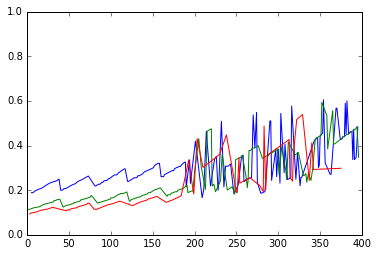

In [27]:
#rank1 = newest[newest["prestige_1.0"]==1]
rank4 = newest[newest["prestige_4.0"]==1]
rank2 = newest[newest["prestige_2.0"]==1]
rank3 = newest[newest["prestige_3.0"]==1]

#plt.plot(rank1['1prob'])
plt.plot(rank2['1prob'])
plt.plot(rank3['1prob'])
plt.plot(rank4['1prob'])
plt.xlim((0,400))
plt.ylim((0,1))


(0, 1)

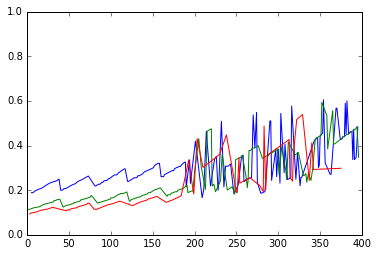

In [28]:
#plt.plot(rank1['1prob'])
plt.plot(rank2['1prob'])
plt.plot(rank3['1prob'])
plt.plot(rank4['1prob'])
plt.xlim((0,400))
plt.ylim((0,1))